# Pokémon TCG Data Analysis

This notebook explores distributions of card rarities, HP distributions by stage, energy‐cost vs. damage relationships, and pack‐level summaries based on your Pokémon TCG CSV.


In [2]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt

# render plots inline
%matplotlib inline


In [3]:
# load the data
# replace the path below with wherever you saved your CSV
df = pd.read_csv("data/full.csv")

# quick peek
df.head()


,number,name,rarity,stage,HP,type,ability_name,ability_effect,move1_name,move1_cost,move1_damage,move1_effect,move2_name,move2_cost,move2_damage,move2_effect,retreat_cost,pack_name,pack_points,image
0,A1 001,Bulbasaur,◇,Basic,70.0,Grass,NaN,NaN,Vine Whip,🟢*️⃣,40,NaN,NaN,NaN,NaN,NaN,1.0,Genetic Apex (A1) Mewtwo,35,https://img.game8.co/3998332/91c4f79b2b3b42062...
1,A1 002,Ivysaur,◇◇,Stage 1,90.0,Grass,NaN,NaN,Razor Leaf,🟢*️⃣*️⃣,40,NaN,NaN,NaN,NaN,NaN,2.0,Genetic Apex (A1) Mewtwo,70,https://img.game8.co/4006820/34e0ae3e3a08bf458...
2,A1 003,Venusaur,◇◇◇,Stage 2,160.0,Grass,NaN,NaN,Mega Drain,🟢🟢*️⃣*️⃣,80,Heal 30 damage from this Pokemon.,NaN,NaN,NaN,NaN,3.0,Genetic Apex (A1) Mewtwo,150,https://img.game8.co/4003548/e62b9303f29d5360a...
3,A1 004,Venusaur ex,◇◇◇◇,Stage 2,190.0,Grass,NaN,NaN,Razor Leaf,🟢*️⃣*️⃣,60,NaN,Giant Bloom,🟢🟢*️⃣*️⃣,100,Heal 30 damage from this Pokemon.,3.0,Genetic Apex (A1) Mewtwo,500,https://img.game8.co/3995580/151d2c9455f838996...
4,A1 005,Caterpie,◇,Basic,50.0,Grass,NaN,NaN,Find a Friend,*️⃣,NaN,Put 1 random Grass Pokemon from your deck into...,NaN,NaN,NaN,NaN,1.0,Genetic Apex (A1) Pikachu,35,https://img.game8.co/4004054/ac3d9d05b0255de5e...


## 1. Rarity Distribution

Count how many cards of each rarity (◇, ◇◇, ◇◇◇, ☆☆, etc.) you have.


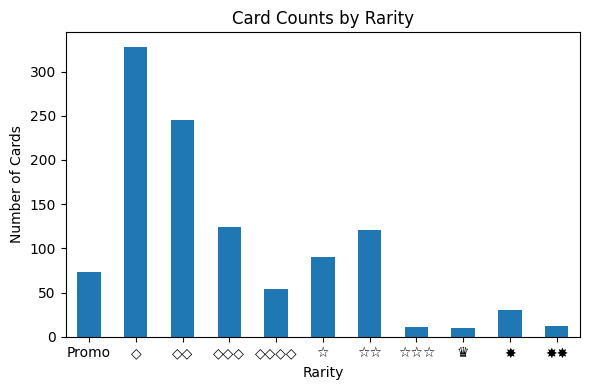

In [4]:
rarity_counts = df["rarity"].value_counts().sort_index()

plt.figure(figsize=(6,4))
rarity_counts.plot(kind="bar")
plt.title("Card Counts by Rarity")
plt.xlabel("Rarity")
plt.ylabel("Number of Cards")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 2. HP Distribution by Stage

Histogram of HP, faceted by evolution stage (Basic, Stage 1, Stage 2).


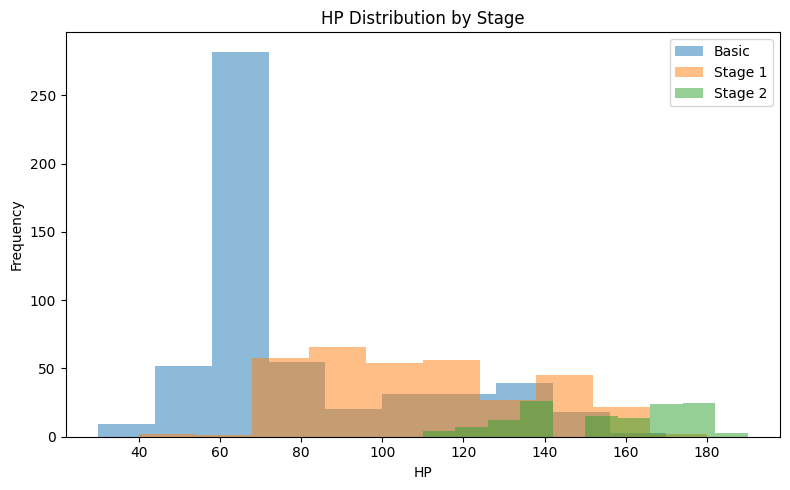

In [5]:
# keep only Pokémon with numeric HP
hp_df = df.dropna(subset=["HP"]).copy()
hp_df["HP"] = pd.to_numeric(hp_df["HP"], errors="coerce")
hp_df = hp_df.dropna(subset=["HP"])

# plot
stages = ["Basic", "Stage 1", "Stage 2"]
plt.figure(figsize=(8,5))
for stage in stages:
    subset = hp_df[hp_df["stage"] == stage]
    if not subset.empty:
        plt.hist(subset["HP"], bins=10, alpha=0.5, label=stage)
plt.title("HP Distribution by Stage")
plt.xlabel("HP")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


## 3. Move 1 Energy Cost vs. Damage

Scatter plot of “number of energy symbols” in move₁’s cost vs. its damage.


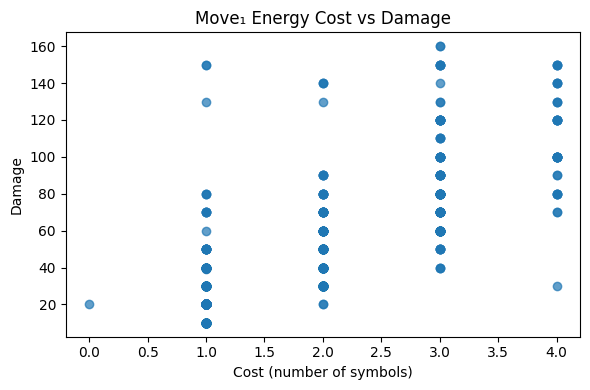

In [6]:
# count cost symbols (approximate by string length) and numeric damage
df["move1_cost"] = df["move1_cost"].str.replace("*️⃣", "*", regex=False)
df["move1_cost_count"] = df["move1_cost"].fillna("").str.len()
df["move1_damage"] = pd.to_numeric(df["move1_damage"], errors="coerce")

# drop rows without damage
scatter_df = df.dropna(subset=["move1_damage"])

plt.figure(figsize=(6,4))
plt.scatter(scatter_df["move1_cost_count"], scatter_df["move1_damage"], alpha=0.7)
plt.title("Move₁ Energy Cost vs Damage")
plt.xlabel("Cost (number of symbols)")
plt.ylabel("Damage")
plt.tight_layout()
plt.show()


## 4. Cards per Pack

Bar chart showing how many cards come from each pack.


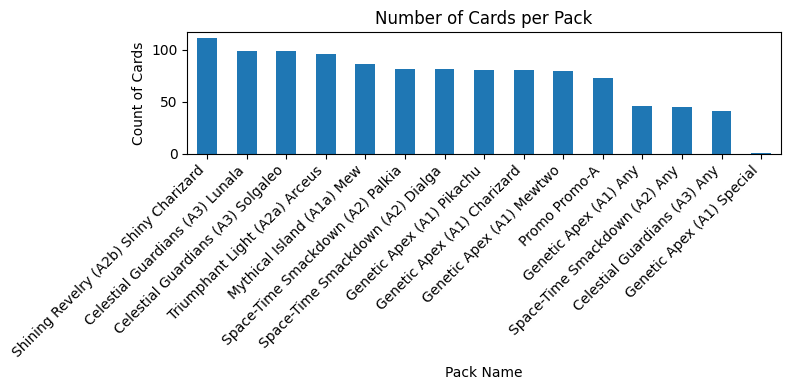

In [7]:
pack_counts = df["pack_name"].value_counts()

plt.figure(figsize=(8,4))
pack_counts.plot(kind="bar")
plt.title("Number of Cards per Pack")
plt.xlabel("Pack Name")
plt.ylabel("Count of Cards")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


---
**Next steps & ideas**

- Add more plots (e.g. average HP by rarity, word-cloud of ability effects).  
- Clean up energy parsing for exact symbol counts.  
- Export these figures for your presentation or report.
